In [100]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [101]:
import numpy as np
import pandas as pd

In [102]:
from datetime import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [103]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [104]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [105]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [106]:
# view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [107]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [108]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

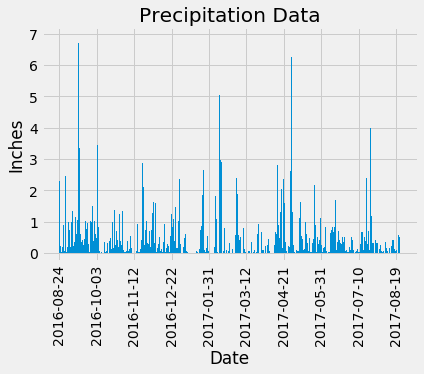

In [109]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Calculate the date 1 year ago from the last data point in the database
#final last data point
final_date = session.query(func.max(Measurement.date)).all()
#convert results to datetime object
final_date = dt.strptime(final_date[0][0], "%Y-%m-%d")
#calculate date 12 months prior to final point
year_ago = final_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > year_ago).all()
precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
precip_df = precip_df.set_index("date")

#drop NANs
precip_df = precip_df.dropna(how="any")

# Sort the dataframe by date
precip_df = precip_df.sort_values("date")
precip_df = precip_df.reset_index()

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precip_df["date"],precip_df["prcp"],width=1.0)
plt.title("Precipitation Data")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(b=True)
ticks = np.arange(0,365,40)
plt.xticks(ticks, rotation="vertical")
plt.ylim(-.25, precip_df["prcp"].max()+.5)
plt.show()

In [110]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [111]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.distinct(Measurement.station)).count()
print(f"There are {station_count} different stations in the dataset.")

There are 9 different stations in the dataset.


In [112]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [113]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
target_station = active_stations[0][0]

station_stats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs))\
                            .filter(Measurement.station == target_station).all()

station_stats_df = pd.DataFrame({"Min Temp":station_stats[0][0],
                               "Max Temp":station_stats[0][1],
                               "Avg Temp":station_stats[0][2]},
                                index=[target_station])

station_stats_df

,Min Temp,Max Temp,Avg Temp
USC00519281,54.0,85.0,71.663781


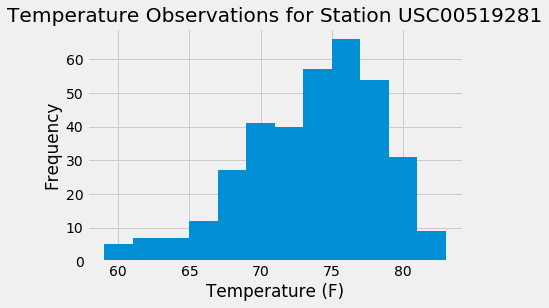

In [114]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#find last data point for target station
final_date = session.query(func.max(Measurement.date))\
                        .filter(Measurement.station == target_station).all()
#convert result to timedate object
final_date = dt.strptime(final_date[0][0], "%Y-%m-%d")
#Calculate the date 1 year ago from the last data point in the database
year_ago = final_date - timedelta(days=365)

#query the last 12 months of temp data for the target station
temp_data = session.query(Measurement.tobs)\
                        .filter(Measurement.date > year_ago)\
                        .filter(Measurement.station == target_station)\
                        .all()

#convert results to list
temps_list = np.ravel(temp_data)

#plot histogram of results
plt.hist(temps_list, bins=12)
plt.title(f"Temperature Observations for Station {target_station}")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.show()


## Bonus Challenge Assignment

In [115]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [116]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2012-02-28'
end_date = '2012-03-05'

TMIN, TAVG, TMAX = calc_temps(start_date, end_date)[0]


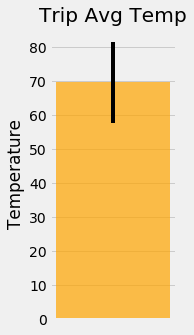

In [117]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
error = TMAX-TMIN

plt.figure(figsize=(2,5))
plt.bar([0],TAVG, yerr=error ,width=.2,color="orange", alpha=.7)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")
plt.xticks(ticks=[])
plt.show()

In [118]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_station = session.query(Measurement.station, func.sum(Measurement.prcp),\
                            Station.name, Station.latitude, Station.longitude, Station.elevation)\
                                .filter(Measurement.station == Station.station)\
                                .filter(Measurement.date >= start_date)\
                                .filter(Measurement.date <= end_date)\
                                .group_by(Measurement.station)\
                                .order_by(func.sum(Measurement.prcp).desc())\
                                .all()
rain_dict = {"station":[],
             "rain total":[],
            "station name":[],
            "latitude":[],
            "longitude":[],
            "elevation":[]}

for x in rain_station:
    rain_dict["station"].append(x[0])
    rain_dict["rain total"].append(x[1])
    rain_dict["station name"].append(x[2])
    rain_dict["latitude"].append(x[3])
    rain_dict["longitude"].append(x[4])
    rain_dict["elevation"].append(x[5])

rain_df = pd.DataFrame(rain_dict)
rain_df

,station,rain total,station name,latitude,longitude,elevation
0,USC00519281,11.08,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00516128,10.32,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00513117,5.79,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00518838,3.84,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
4,USC00519523,2.92,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,USC00519397,1.18,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00511918,0.76,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,USC00514830,0.03,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
8,USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [119]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [120]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
starting = dt.strptime(start_date, "%Y-%m-%d")
ending = dt.strptime(end_date, "%Y-%m-%d")

# Use the start and end date to create a range of dates
trip_length = (ending - starting).days

# Stip off the year and save a list of %m-%d strings
trip_days_str = []
for x in range(trip_length+1):
    trip_days_str.append(dt.strftime(starting + timedelta(days=x), "%m-%d"))
    
# Loop through the list of %m-%d strings and calculate the normals for each date
for day in trip_days_str:
    normals.append(daily_normals(day))

normals

[[(65.0, 70.65517241379311, 80.0)],
 [(67.0, 71.73333333333333, 79.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [121]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#convert previous result into list of lists (from list of lists of tuples)
normals_ravel = []
for x in normals:
    normals_ravel.append(np.ravel(x))

#create dataframe, add dates column, set index to date column    
normals_df = pd.DataFrame(normals_ravel, columns =['tmin', 'tavg', 'tmax'])
normals_df["date"] = trip_days_str
normals_df = normals_df.set_index("date")
normals_df

,tmin,tavg,tmax
date,,,
02-28,65.0,70.655172,80.0
02-29,67.0,71.733333,79.0
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0


Text(0, 0.5, 'temperature')

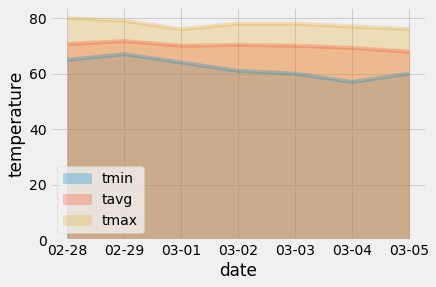

In [122]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normals_df.plot.area(stacked=False,alpha=.3)
ax.set_ylabel("temperature")